# Imprisonment by Race

This notebook explores 

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
%matplotlib inline

In [19]:
# Importing modules from a visualization package.
# from bokeh.sampledata.us_states import data as states|
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.models import LinearColorMapper, ColorBar, BasicTicker

In [5]:
CSV_PATH = os.path.join('data', 'prison', 'p16t03.csv')
race_sex_raw = pd.read_csv(CSV_PATH, 
                           encoding='latin1',
                           header=11, 
                           na_values=':',
                           thousands=r',')
race_sex_raw.dropna(axis=0, thresh=3, inplace=True)
race_sex_raw.dropna(axis=1, thresh=3, inplace=True)
race_sex_raw.dropna(axis=0, inplace=True)
fix = lambda x: x.split('/')[0]
race_sex_raw['Year'] = race_sex_raw['Year'].apply(fix)
race_sex_raw.columns = [x.split('/')[0] for x in race_sex_raw.columns]
race_sex_raw.set_index('Year', inplace=True)

In [6]:
race_sex_raw

,Total,Federal,State,Male,Female,White,Black,Hispanic
Year,,,,,,,,
2006,1504598.0,173533.0,1331065.0,1401261.0,103337.0,507100.0,590300.0,313600.0
2007,1532851.0,179204.0,1353647.0,1427088.0,105763.0,499800.0,592900.0,330400.0
2008,1547742.0,182333.0,1365409.0,1441384.0,106358.0,499900.0,592800.0,329800.0
2009,1553574.0,187886.0,1365688.0,1448239.0,105335.0,490000.0,584800.0,341200.0
2010,1552669.0,190641.0,1362028.0,1447766.0,104903.0,484400.0,572700.0,345800.0
2011,1538847.0,197050.0,1341797.0,1435141.0,103706.0,474300.0,557100.0,347800.0
2012,1512430.0,196574.0,1315856.0,1411076.0,101354.0,466600.0,537800.0,340300.0
2013,1520403.0,195098.0,1325305.0,1416102.0,104301.0,463900.0,529900.0,341200.0
2014,1507781.0,191374.0,1316407.0,1401685.0,106096.0,461500.0,518700.0,338900.0


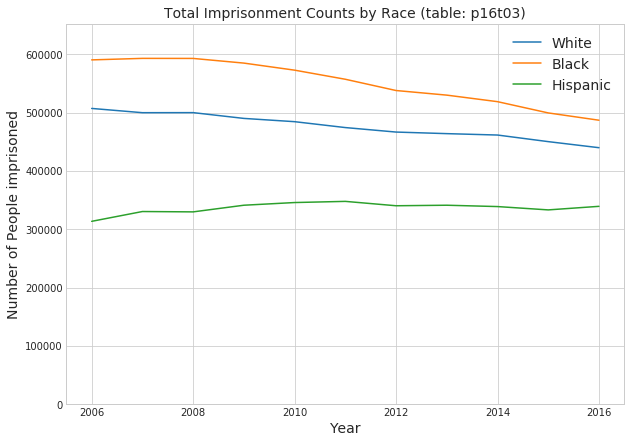

In [7]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(race_sex_raw['White'])
    ax.plot(race_sex_raw['Black'])
    ax.plot(race_sex_raw['Hispanic'])
    ax.set_title('Total Imprisonment Counts by Race (table: p16t03)',fontsize=14)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Number of People imprisoned', fontsize=14)
    ax.legend(fontsize=14)
    ax.set_ylim([0, 1.1*max([race_sex_raw['White'].max(), 
                             race_sex_raw['Black'].max(),
                             race_sex_raw['Hispanic'].max()])])

Looking at this plot of total imprisonment counts, we see that:
* At any given time, there are more non-Hispanic black people in prison than any other race.
* At any given time, there are more non-Hispanic white people than Hispanic people in prison.
* The numbers of imprisoned black people and white people decreased steadily from 2008 to 2016, while the number of imprisoned Hispanic people was been fairly flat over that time.

These numbers are raw counts, so they don't account for the fact that the fact that these races make up different proportions of the entire US population. This motivates questions like:

* What percent of the population of each race is in prison?

To answer that, I'll have to find population data broken down by race.


### Census Data

The Constitution requires that a full, national census is performed every 10 years that reaches every resident on American soil. This data is used to determine how much federal money is allocated to each district for things like schools, roadways, police, etc. and it determines how many congressional representatives will be allocated to each state. With the help of smaller surveys, the US Census bureau makes estimates of populations for the years between censuses.

https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk

In [8]:
CSV_PATH = os.path.join('data', 'pop', 'PEP_2016_PEPSR6H_with_ann.csv')
race_pop = pd.read_csv(CSV_PATH, header=[1], encoding='latin1')
print('Initial Data Format:')
display(race_pop.head())
# Only looking for national values
race_pop = race_pop[race_pop['Geography'] == 'United States']
# Eliminating the actual census values
race_pop = race_pop[~race_pop['Year'].str.contains('April')]
# Eliminating aggregated rows
race_pop = race_pop[race_pop['Hispanic Origin'] != 'Total']
# race_pop = race_pop[race_pop['Sex'] != 'Both Sexes']  # for later
race_pop = race_pop[~race_pop['Sex'].isin(['Male','Female'])]

drop_cols = ['Id', 'Id.1', 'Id.2', 'Id2', 'Id.3', 'Geography', 'Sex',
             'Race Alone - American Indian and Alaska Native', 'Race Alone - Asian',
             'Race Alone - Native Hawaiian and Other Pacific Islander']
race_pop.drop(drop_cols, axis=1, inplace=True)

# Reducing the size of long column names
col_map = {'Race Alone - Black or African American':'black_only_pop',
           'Race Alone - White': 'white_only_pop'}
race_pop.rename(col_map, axis=1, inplace=True)

print('\nData Format after Processing:')
race_pop.head()

Initial Data Format:


,Id,Year,Id.1,Sex,Id.2,Hispanic Origin,Id.3,Id2,Geography,Total,Race Alone - White,Race Alone - Black or African American,Race Alone - American Indian and Alaska Native,Race Alone - Asian,Race Alone - Native Hawaiian and Other Pacific Islander,Two or More Races
0,cen42010,"April 1, 2010 Census",female,Female,hisp,Hispanic,0100000US,NaN,United States,24858794,21936806,1191984,702309,249346,85203,693146
1,cen42010,"April 1, 2010 Census",female,Female,nhisp,Not Hispanic,0100000US,NaN,United States,132105418,100301335,19853611,1147502,7691693,246518,2864759
2,cen42010,"April 1, 2010 Census",female,Female,tothisp,Total,0100000US,NaN,United States,156964212,122238141,21045595,1849811,7941039,331721,3557905
3,cen42010,"April 1, 2010 Census",male,Male,hisp,Hispanic,0100000US,NaN,United States,25618800,22681299,1136129,773939,248654,92206,686573
4,cen42010,"April 1, 2010 Census",male,Male,nhisp,Not Hispanic,0100000US,NaN,United States,126162526,97017621,18068911,1115756,6969823,250698,2739717



Data Format after Processing:


,Year,Hispanic Origin,Total,white_only_pop,black_only_pop,Two or More Races
24,"July 1, 2010",Hispanic,50754069,44855529,2343053,1392607
25,"July 1, 2010",Not Hispanic,258594124,197394319,38015461,5647760
33,"July 1, 2011",Hispanic,51906353,45841771,2410490,1445820
34,"July 1, 2011",Not Hispanic,259757005,197519026,38393758,5826406
42,"July 1, 2012",Hispanic,52993496,46759165,2480193,1498388


Based on the aggregation of the data I pulled, there is a rather vague 'Two or More Races' column. The prisoner data I've been working with has not differentiated between multiracial people and single-race people, rather, the prison data only breaks races down to non-Hispanic white, non-Hispanic black, and Hispanic. It's entirely possible for someone to be non-Hispanic, black, and multiracial, which would make it much more difficult and less accurate to use this population data with the prison data. Fortunately, however, the [documentation for the prison data](https://www.bjs.gov/content/pub/pdf/p16.pd)] includes footnotes indicating the data for white and black prison populations excludes persons of two or more races, so, conveniently, I must also exclude it.

In [9]:
race_pop.drop('Two or More Races', axis=1, inplace=True)

In [10]:
hisp = race_pop[race_pop['Hispanic Origin'] == 'Hispanic'].copy()
non_hisp = race_pop[race_pop['Hispanic Origin'] != 'Hispanic'].copy()
non_hisp.drop(['Hispanic Origin', 'Total'], axis=1, inplace=True)
hisp.drop(['white_only_pop','black_only_pop', 'Hispanic Origin'], axis=1, inplace=True)
hisp.rename({'Total':'Hispanic_pop'}, axis=1, inplace=True)
us_race_pop = hisp.merge(non_hisp, on=['Year'])
fix_yr = lambda x: x.split(' ')[-1]
us_race_pop['Year'] = us_race_pop['Year'].apply(fix_yr)
us_race_pop.set_index('Year', inplace=True)

This provides population data from 2010 on, but not for the earlier years. To deal with earlier years, I need to handle another data set. 

https://www.census.gov/data/tables/time-series/demo/popest/intercensal-2000-2010-national.html

In [11]:
EXCEL_PATH = os.path.join('data', 'pop', 'us-est00int-02.xls')
race_pop0010 = pd.read_excel(EXCEL_PATH, header=None)
race_pop0010.dropna(axis=0, thresh=6, inplace=True)
race_pop0010.drop([1],axis=1, inplace=True)
race_pop0010 = race_pop0010.T
race_pop0010.iloc[0,0] = 'Year'
race_pop0010.columns = race_pop0010.loc[0]
race_pop0010.drop(0, axis=0, inplace=True)
race_pop0010.dropna(axis=0, inplace=True)
race_pop0010['Year'] = race_pop0010['Year'].astype(int)
race_pop0010['Year'] = race_pop0010['Year'].astype(str)
race_pop0010.set_index('Year', inplace=True)

In [12]:
# Code to help drop columns I'm not interested in
drop_cols = []
drop_stumps = ['AIAN','Asian','NHPI', 'One Race', 'Two or']
for col in race_pop0010.columns:
    if any(x in col for x in drop_stumps):
        drop_cols.append(col)
race_pop0010.drop(drop_cols, axis=1, inplace=True)

# Code to facilitate merging this DataFrame with theother Population DataFrame
both0010 = race_pop0010.iloc[:,4:7].copy()
name_map = {'...White'  : 'white_only_pop',
            '...Black'  : 'black_only_pop',
            '.HISPANIC' : 'Hispanic_pop'}
both0010.rename(name_map, axis=1, inplace=True)
both0010 = both0010.astype(int)
pop_span = pd.concat([both0010, us_race_pop], join='inner')
race_sex_pop = race_sex_raw.join(pop_span)

Now that I've got a full population data set, I can normalize the prisoner data.

In [13]:
race_sex_pop.loc[:,'White_pct'] = race_sex_pop.loc[:,'White']\
                .divide(race_sex_pop.loc[:,'white_only_pop']) * 100
race_sex_pop.loc[:,'Black_pct'] = race_sex_pop.loc[:,'Black']\
                .divide(race_sex_pop.loc[:,'black_only_pop']) * 100
race_sex_pop.loc[:,'Hispanic_pct'] = race_sex_pop.loc[:,'Hispanic']\
                .divide(race_sex_pop.loc[:,'Hispanic_pop']) * 100

In [14]:
race_sex_pop

,Total,Federal,State,Male,Female,White,Black,Hispanic,white_only_pop,black_only_pop,Hispanic_pop,White_pct,Black_pct,Hispanic_pct
Year,,,,,,,,,,,,,,
2006,1504598.0,173533.0,1331065.0,1401261.0,103337.0,507100.0,590300.0,313600.0,196832697,36520961,44606305,0.257630,1.616332,0.703040
2007,1532851.0,179204.0,1353647.0,1427088.0,105763.0,499800.0,592900.0,330400.0,197011394,36905758,46196853,0.253691,1.606524,0.715200
2008,1547742.0,182333.0,1365409.0,1441384.0,106358.0,499900.0,592800.0,329800.0,197183535,37290709,47793785,0.253520,1.589672,0.690048
2009,1553574.0,187886.0,1365688.0,1448239.0,105335.0,490000.0,584800.0,341200.0,197274549,37656592,49327489,0.248385,1.552982,0.691704
2010,1552669.0,190641.0,1362028.0,1447766.0,104903.0,484400.0,572700.0,345800.0,197394319,38015461,50754069,0.245397,1.506492,0.681325
2011,1538847.0,197050.0,1341797.0,1435141.0,103706.0,474300.0,557100.0,347800.0,197519026,38393758,51906353,0.240129,1.451017,0.670053
2012,1512430.0,196574.0,1315856.0,1411076.0,101354.0,466600.0,537800.0,340300.0,197701109,38776276,52993496,0.236013,1.386931,0.642154
2013,1520403.0,195098.0,1325305.0,1416102.0,104301.0,463900.0,529900.0,341200.0,197777454,39135988,54064149,0.234557,1.353997,0.631102
2014,1507781.0,191374.0,1316407.0,1401685.0,106096.0,461500.0,518700.0,338900.0,197902336,39507913,55189962,0.233196,1.312902,0.614061


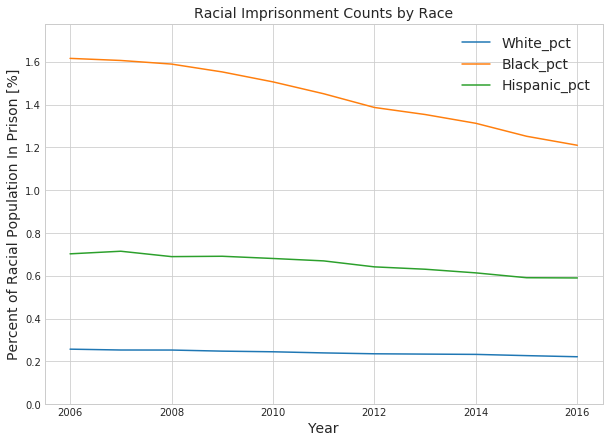

In [15]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(race_sex_pop['White_pct'])
    ax.plot(race_sex_pop['Black_pct'])
    ax.plot(race_sex_pop['Hispanic_pct'])
    ax.set_title('Racial Imprisonment Counts by Race',fontsize=14)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Percent of Racial Population In Prison [%]', fontsize=14)
    ax.legend(fontsize=14)
    ax.set_ylim([0, 1.1*max([race_sex_pop['White_pct'].max(), 
                             race_sex_pop['Black_pct'].max(),
                             race_sex_pop['Hispanic_pct'].max()])])

In [17]:
# This Cell normalizes prisoner counts to be per 100k 
#   state population for that year.
yrs = ['2015','2016']
sexes = ['Male','Female']

for yr in yrs:
    for sex in sexes:
        state_sex_join_df.loc[:,(yr, sex + '_rate')] = \
            state_sex_join_df.loc[:,(yr, sex)]\
            .divide(state_sex_join_df.loc[:,(yr + '_pop', sex)]/100000)

NameError: name 'state_sex_join_df' is not defined

In [ ]:
race_pop0010.iloc[:,9:]

In [ ]:
race_pop0010.columns[0] = 'Year'

In [ ]:
race_pop0010

In [ ]:
race_pop.head()